# Pre-processing wiki text

## Filter by list of pages of interest

In [ ]:
import pandas as pd
import numpy as np

### Get list of pages from catscan

In [ ]:
df = pd.read_csv('data/materials-pages', error_bad_lines = False)


In [ ]:
df.head()

In [ ]:
pageDict = {" ".join(page.split('_')):0 for page in df['title']}

In [ ]:
pageDict

### JSON pre-processed dump

#### Search for articles in dump by title

In [ ]:
#this works in python 2.7 but not in 3.6
#try finding files by title
import os
import bz2
import json
import time

t0 = time.time()

if 0==0:
    writefile = "data/wiki_proc_filt.json"
    written = 0
    with open(writefile, 'w') as fwrite:
        dirs = os.listdir('data/wiki_processed')
        for folder in dirs:
            filelist = os.listdir("data//wiki_processed//"+folder)
            for filename in filelist: 
                filepath = "data//wiki_processed//" + "//".join([folder, filename])
                with bz2.BZ2File(filepath, 'r') as fread:
                    for line in fread:
                        d = json.loads(line)
                        if d['title'] in pageDict:
                            written +=1
                            fwrite.write(line)       


    print("Searched for " + str(len(pageDict)) + " titles.")
    print(str(written) + " titles found and written to " + writefile)
    
t = time.time()
print("time taken = " + str(t-t0) + "s.")

#### Search for articles in dump by "id"

Our list of articles in the category 'materials' with depth = 5 had 197530 articles. Searching by title, only 164600 of those were found in the processed wikipedia dump. This might be because the catscan is more recent than the dump. 

Let's try to search instead by "id" rather than "title". 

In [ ]:
#this works in python 2.7 but not in 3.6
import time

t0 = time.time()

#make the if statement true if you want to run this. May take a few minutes. 

if 1==1:

    idDict = {id:0 for id in df["pageid"]}
    writefile = "data/wiki_proc_filt_id.json"
    writtenId = 0
    with open(writefile, 'w') as fwrite:
        dirs = os.listdir('data/wiki_processed')
        for folder in dirs:
            filelist = os.listdir("data//wiki_processed//"+folder)
            for filename in filelist: 
                filepath = "data//wiki_processed//" + "//".join([folder, filename])
                with bz2.BZ2File(filepath, 'r') as fread:
                    for line in fread:
                        d = json.loads(line)
                        if int(d['id']) in idDict:
                            writtenId +=1
                            fwrite.write(line)
                                
    
    print("Searched for " + str(len(idDict)) + " titles.")
    print(str(writtenId) + " titles found and written to " + writefile)
    
t = time.time()
print("Time taken: " + str(t-t0) + "s")

Even after searching by id, about 27000 articles are missing. We will go ahead and process the articles we could find. 

There is one complication in the dump I have processed. We need the dump with the links, but the one I have is without links. The idea behind preserving the links is that we should convert phrases within a link into a single entity - an n-gram. So below I obtained a different pre-processed dump. 

### Analyzing another pre-processed dump

This file is tab separated. Each section is written as a new entry. Also contains references. 
1. If there's a link, join words within the link by underscores to use it as a phrase
2.  Write the output to a new file in json format
3. Join sections so that each article is one entry.
4. Add a new entry in the json file with section names for each article

In [ ]:
import re

def join_links(example):
    pattern = re.compile(r'(<a href\")(.*?)(\">)(.*?)(</a>)')
    matches = pattern.findall(example)
    for match in matches:
        #print(match)
        t = ''.join(x for x in match)
        example = example.replace(t, match[1].replace(" ","_"))
    return example
    #print(example)

In [ ]:
readfile = open("data//wiki_materials_rows_out.txt", 'r')
tempfile = open("data/link_joined.txt", 'w')
t0 = time.time()
i=0
for line in readfile:
    line = join_links(line)
    tempfile.write(line)
    
t = time.time()
print("Time taken = " + str(t-t0) + "s.")
tempfile.close()

Let's take a look at how the file looks now

In [ ]:
readfile = open("data//link_joined.txt", 'r')

i=0
for line in readfile:
    if i<2:
        example=line
    elif i<5:
        print(line)
    else:   
        break
    i+=1
    
readfile.close()

For ease of working, convert the tab separated .txt file into json file

In [ ]:
t0 = time.time()
lines_read = 0
lines_write = 0
with open("data/link_joined.txt", 'r') as readfile:
    with open("data/link_joined.json", 'w') as writefile:
        for line in readfile: 
            lines_read+=1
            data = line.split('\t')
            if len(data)==6:
                lines_write += 1
                line = {"id" : data[0], "title" : data[1], "section" : data[2], "text" : data[5]} 
                d = json.dumps(line)
                writefile.write(d+'\n')
print(str(lines_read) + " lines read.")
print(str(lines_write) + " lines written. ")
                
t = time.time()
print("time taken = " + str(t-t0) + "s.")

Make sure we still have all the articles we started with ~166000

In [ ]:
title_dict = {}
with open("data/link_joined.json") as f_r: # | wc -l
    i = 0
    for line in f_r:
        #if i>10:
        #    break
        d = json.loads(line)  
        title_dict[d['title']] = 1
        i+=1
        
print(len(title_dict))

Fuse text for same title together
Assume that text from the same article is consecutive. Once an article ends, it never restarts again

In [ ]:
#n_line = 0
t0 = time.time()
titles = 0
n_line = 1
with open("data/link_joined.json", 'r') as readfile:
    with open("data/titles_joined.json", 'w') as writefile:
        for line in readfile:
            if 0==0:
                d = json.loads(line)
                n_line += 1
                if n_line==1:
                    id_prev = d["id"]
                    title_prev = d["title"]
                    text_prev = d["text"]
                    section_prev = d["section"]
                    sections = d["section"] 
                    #new_title = 0
                elif d["id"] == id_prev:
                    new_title = 0
                    text_prev = text_prev + "\n" + d["text"]
                    if d["section"] != section_prev: 
                        sections = sections + "," + d["section"]
                else:
                    titles+=1
                    #new_title = 1
                    #print(title_prev)
                    writeline = {"id": id_prev, "title": title_prev, "section": sections, "text": text_prev}
                    writeline = json.dumps(writeline)
                    writefile.write(writeline + '\n')
                    id_prev = d["id"]
                    title_prev = d["title"]
                    text_prev = d["text"]
                    section_prev = d["section"]
                    sections = d["section"] 

print(str(titles) + " written.")
t = time.time()
print("time taken = " + str(t-t0) + "s.")


Make a list of titles

In [ ]:
titles = {}
with open('data/titles_joined.json', 'r') as readfile:
    for line in readfile:
        d = json.loads(line)
        title = d['title'].replace(" ", "_")
        titles[title] = 0
len(titles)

In [ ]:
titles.keys()[5]

## Get categories for each title from dbpedia

WikiExtractor does not import the category information for each article by default. However dbpedia stores a lot of structured information about each wikipedia article such as category names, templates, info-boxes etc. 

Let's get the categories info from dbpedia. 

In [ ]:
from collections import defaultdict
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('error')
t0 = time.time()
titles_cat = defaultdict(list)
with open('data/article_categories_en.ttl', 'r') as readfile:
    n=0
    for line in readfile:
        if n==0 or len(line.split(">"))<2:
            n+=1
            continue
        n=n+1
        t_db = line.split("<http://dbpedia.org/resource/")[1].split(">")[0]
        t_db = t_db.decode('utf-8')

        if t_db in titles: 
            cat = line.split("<http://dbpedia.org/resource/")[2].split(":")[1].split(">")[0]
            titles_cat[t_db].append(cat)            
        if 0==1:
            break
t = time.time()
print("Extracted categories for " + str(len(titles_cat.keys())) + " titles in " + str(t-t0) + "s.")

In [ ]:
notfound = []
for key in titles.keys():
    if key in titles_cat:
        continue
    else:
        notfound.append(key)

In [ ]:
for x in notfound:
    print(x)
    #print(x.encode('ascii', 'ignore'))

In [ ]:
with open('data/titles_cat.json', 'w') as writefile:
    json.dump(titles_cat, writefile)

In [ ]:
t0 = time.time()
titles = 0
with open('data/wiki_final_processed.json', 'w') as writefile:
    with open ('data/titles_joined.json', 'r') as readfile:
        for line in readfile:
            d = json.loads(line)
            d['title'] = d['title'].replace(" ", "_")
            if d['title'] in titles_cat:
                titles += 1
                d['category'] = titles_cat[d['title']]
                writeline = json.dumps(d)
                writefile.write(writeline + '\n')
t = time.time()
print("Wrote categories for " + str(titles) + " articles in " + str(t-t0) + "s.")

We have a list of articles under each category. Let's also get a list of categories for each article, by storing in a data structure called default dict. 

In [1]:
import json
from collections import defaultdict
ids = []
categories = []
n=0
cat_titles = defaultdict(list)
with open('data/wiki_final_processed.json','r') as readfile:
    for line in readfile:
        d = json.loads(line)
        n+=1
        for category in d['category']:
            cat_titles[category].append(d['title'])

### Store categories and article names in a pandas dataframe

We will store this in a pandas dataframe for easy filtering and querying. 

In [ ]:
cats = pd.DataFrame.from_dict(cat_items, orient = 'index')

In [ ]:
stemmer2.stem('gardening')

In [91]:
cats_df = pd.DataFrame(list(cat_titles.items()), columns=['category', 'articles'])
cats_df.head()

category  \
0                  Climate_forcing   
1                      Climatology   
2        Electromagnetic_radiation   
3  Land_surface_effects_on_climate   
4                       Radiometry   

                                            articles  
0  [Albedo, Greenhouse_effect, Global_warming_pot...  
1  [Albedo, Drought, Extreme_weather, Weathering,...  
2  [Albedo, Aberration_of_light, Beer–Lambert_law...  
3  [Albedo, Rain_shadow, Land_surface_effects_on_...  
4  [Albedo, Crookes_radiometer, Radiometry, Pyrom...

Sort the dataframe based on the number of articles in each category, so that we can focus on categories with the most articles. 

In [92]:
cats_df['n_articles'] = [len(cats_df.iloc[i][1]) for i in range(len(cats_df))]
cats_df.sort_values('n_articles', axis=0, ascending=False, inplace=True, na_position='last')

In [77]:
cats_df.to_csv('data\cats_articles', index=False, header = True)
#cats_df = pd.read_csv('data\cats_articles')
cats_df.head()

category  \
0                   Living_people   
1                  American_films   
2  American_black-and-white_films   
3    Enzymes_of_unknown_structure   
4          English-language_films   

                                            articles  n_articles  
0  ['Anatoly_Karpov', 'Anita_Hill', 'Dale_Chihuly...        3536  
1  ['The_Birth_of_a_Nation', 'King_Kong_(1933_fil...        3438  
2  ['The_Birth_of_a_Nation', 'King_Kong_(1933_fil...        3036  
3  ['L-lactate_dehydrogenase_(cytochrome)', '1,4-...        2087  
4  ['King_Kong_(1933_film)', 'U-571_(film)', 'Cro...        1964

In [49]:
cats_df.iloc[:300, [0,2]].to_csv('data\cats_articles300', index = False)

## Tokenize with Spacy and save to file

In [120]:
import spacy
import time
import json

In [2]:
nlp = spacy.load('en')
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [3]:
t0 = time.time()
count = 0

with open('data/wiki_final_processed.json', 'r') as readfile:
    with open('data/wiki_tokenized.json', 'w') as writefile:
        for line in readfile:
            d = json.loads(line)
            tokens = [str(token) for token in tokenizer(d['text'])]
            d['text'] = " ".join(tokens)
            writefile.write(json.dumps(d) + '\n') 
            count += 1
            if count%10000 == 0:
                print(d['text'][:30], tokens[:4])
                print("Tokenized", count, "articles")
t= time.time()
print(t-t0)

Lucky Jim is a novel by Kingsl ['Lucky', 'Jim', 'is', 'a']
Tokenized 10000 articles
A hydraulic press is a device  ['A', 'hydraulic', 'press', 'is']
Tokenized 20000 articles
Inertron is a fictional metal  ['Inertron', 'is', 'a', 'fictional']
Tokenized 30000 articles
A focusing screen is a flat tr ['A', 'focusing', 'screen', 'is']
Tokenized 40000 articles
Ray-Ban Wayfarer sunglasses ha ['Ray-Ban', 'Wayfarer', 'sunglasses', 'have']
Tokenized 50000 articles
A gate dielectric is a dielect ['A', 'gate', 'dielectric', 'is']
Tokenized 60000 articles
Lyrick Studios was an American ['Lyrick', 'Studios', 'was', 'an']
Tokenized 70000 articles
In enzymology, an adenosylmeth ['In', 'enzymology,', 'an', 'adenosylmethionine']
Tokenized 80000 articles
Dancing on Coral is a Miles_Fr ['Dancing', 'on', 'Coral', 'is']
Tokenized 90000 articles
Difluorocarbene is the chemica ['Difluorocarbene', 'is', 'the', 'chemical_compound']
Tokenized 100000 articles
6-(2-Aminopropyl)-2,3-dihydrob ['6-(2-Aminopropyl)-2,3

## Stemming with NLTK 

In [16]:
import nltk
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Astha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
stemmer.stem('running')

'run'

### Data pre-processing for a 5-class chemical-physics classifier

From among the 300 most frequent categories, I have picked 5 categories to train a classifier on. For a single label classifier, let's make sure that the categories don't share a significant number of articles. 

In [78]:
choose = ['Fluid_dynamics', 'Quantum_mechanics', 'Condensed_matter_physics', 'Limestone_caves', 'Acoustics']

In [111]:
#from sets import Set
intersect = []
for i, cat_1 in enumerate(choose):
    for j, cat_2 in enumerate(choose):
        if i<=j:
            continue
        art_1 = set(cats_df[cats_df['category' ] == cat_1]['articles'].tolist()[0])
        #print(art_1)
        art_2 = set(cats_df[cats_df['category' ] == cat_2]['articles'].tolist()[0])
        #intersect.append(len(list(art_1.intersection(art_2))))
        print(cat_1, cat_2, len(list(art_1.intersection(art_2))))
    

Quantum_mechanics Fluid_dynamics 0
Condensed_matter_physics Fluid_dynamics 2
Condensed_matter_physics Quantum_mechanics 17
Limestone_caves Fluid_dynamics 0
Limestone_caves Quantum_mechanics 0
Limestone_caves Condensed_matter_physics 0
Acoustics Fluid_dynamics 8
Acoustics Quantum_mechanics 0
Acoustics Condensed_matter_physics 0
Acoustics Limestone_caves 0


Some categories have some common articles, but less than 10% are common. Notably, :
1. Condensed_matter_physics and Quantum_mechanics have the highest # of articles in common. 
2. Limestone_caves is the most separate category from the remaining 4. 

Let's write all the tokenized text for this selected set of articles to a file. 

In [116]:
arts = defaultdict(list)
for cat in choose:
    articles = cats_df[cats_df['category']==cat]['articles'].tolist()[0]
    for art in articles:
        arts[art].append(cat)

In [108]:
cats_df[cats_df['category']==choose[0]]['articles'].tolist()[0]

['Acoustic_theory',
 'Cavitation',
 'Fluid',
 'Fluid_dynamics',
 'Jet_engine',
 'Microfluidics',
 'Mach_number',
 'Pressure',
 'Superfluid_helium-4',
 'Drop_(liquid)',
 'Viscometer',
 'Power_number',
 'Soliton',
 'Strouhal_number',
 'Péclet_number',
 'Aerosol',
 'Prandtl_number',
 'Nusselt_number',
 'Grashof_number',
 'Potential_flow',
 'Rayleigh_number',
 "Bernoulli's_principle",
 'Non-Newtonian_fluid',
 'Deborah_number',
 'Supercavitation',
 'Surface_tension',
 'Speed_of_sound',
 'Turbulence',
 'Vortex',
 'Gravity_wave',
 'Mean_flow',
 'Atmospheric_sciences',
 'Vorticity',
 'Compressibility',
 'Baroclinity',
 'Drag_coefficient',
 'Magnetohydrodynamic_drive',
 "Stokes'_law",
 'Stream_function',
 'Capillary_action',
 'Flow_measurement',
 'Wake',
 'Adverse_pressure_gradient',
 'Hydraulic_fluid',
 'Weissenberg_number',
 'Pitch_drop_experiment',
 'Terminal_velocity',
 'Wave_drag',
 'Superheating',
 'Hydraulic_jump',
 'Inflatable',
 'Magnus_effect',
 "Archimedes'_principle",
 'Soundproofin

In [119]:
import json
written = 0
with open('data\wiki_tokenized.json', 'r') as readfile:
    with open('data\physchemx.json', 'w') as writefile:
        for line in readfile:
            d = json.loads(line)
            if d['title'] in arts:
                written+= 1
                d['category'] = arts[d['title']]
                writeline = json.dumps(d)
                writefile.write(writeline + '\n')
print("written", written, "articles")

written 1920 articles


### 5 class single label classifier

In [127]:
import pandas as pd
data = pd.read_json('data\physchemx.json', lines = True)
data.head()

category    id  \
0                  [Acoustics]  1198   
1  [Fluid_dynamics, Acoustics]  1234   
2   [Condensed_matter_physics]  4474   
3          [Quantum_mechanics]  4542   
4   [Condensed_matter_physics]  5346   

                                             section  \
0  Abstract,History,History,History,History,Histo...   
1  Abstract,Derivation of the governing equations...   
2  Abstract,History,History,History,History,Criti...   
3  Abstract,Usage,Usage,Usage,Usage,Usage,Usage,V...   
4  Abstract,Classification,Classification,Classif...   

                                                text                     title  
0  Acoustics is the interdisciplinary science tha...                 Acoustics  
1  Acoustic theory is a scientific field that rel...           Acoustic_theory  
2  A Bose–Einstein condensate (BEC) is a state_of...  Bose–Einstein_condensate  
3  In quantum_mechanics, bra–ket notation is a st...          Bra–ket_notation  
4  A colloid, in chemistry, is a mixture in which...                   Colloid

In [128]:
titles = data['title']
X_raw = data['text']
y_raw = data['category']
y = [y[0] for y in y_raw] #keep only 1st category if there are multiple categories for a title

The function text_process removes punctuation and stop-words. This will be passed to the count-vectorizer from sklearn. 

In [129]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
punc_dict = dict((s,1) for s in string.punctuation)
stop_dict = dict((c,1) for c in STOP_WORDS)
stop_dict['\n\n'] = 1
stop_dict['\n'] = 1
punc_dict.pop('_', None)
#make all lowercase, remove punctuation and stop words
def text_process(text, punc_dict= punc_dict, stop_dict=stop_dict):
    nopunc = ""
    text = text.lower()
    for char in text:
        if char not in punc_dict:
            nopunc += char
    processed = [word for word in nopunc.split(" ") if word not in stop_dict]
    return processed

Let's see what it does. It creates a list of words - tokens for each text that is passed to it. 

In [131]:
text_process(X_raw[1])

['acoustic',
 'theory',
 'scientific',
 'field',
 'relates',
 'description',
 'soundlongitudinal_and_transverse_waves',
 'derives',
 'fluid_dynamics',
 'acoustics',
 'engineering',
 'approach',
 'propagation',
 'sound',
 'waves',
 'fluid',
 'water',
 'modeled',
 'equation',
 'continuity',
 'conservation',
 'mass',
 'equation',
 'motion',
 'conservation',
 'momentum',
 '',
 'simplifications',
 'particular',
 'constant',
 'density',
 'given',
 'follows',
 '',
 'formula_1',
 'formula_2',
 'acoustic',
 'pressure',
 'formula_3',
 'flow_velocity',
 'vector',
 'formula_4',
 'vector',
 'spatial',
 'coordinates',
 'formula_5',
 'formula_6',
 'time',
 'formula_7',
 'static',
 'mass',
 'density',
 'medium',
 'formula_8',
 'bulk_modulus',
 'medium',
 'bulk',
 'modulus',
 'expressed',
 'terms',
 'density',
 'speed',
 'sound',
 'medium',
 'formula_9',
 '',
 'formula_10',
 'flow',
 'velocity',
 'field',
 'irrotational',
 'formula_11',
 'acoustic_wave_equation',
 'combination',
 'sets',
 'balance',
 '

#### Split data into test and train sets

In [132]:
from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw,y, test_size = 0.3, random_state = 101)

#### Vectorize using sklearn

In [134]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = text_process)
vector_fit = vectorizer.fit(X_raw)

In [135]:
X = vector_fit.transform(X_raw)
X_train = vector_fit.transform(X_train_raw)
X_test = vector_fit.transform(X_test_raw)

#### Check the sparsity

In [136]:
density= X.nnz/X.shape[0]/X.shape[1]*100
print(density)

0.37775081116238585


#### Naive Bayes classifier

In [139]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
fit = model.fit(X_train, y_train)
predict = model.predict(X_test)

In [140]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, predict))
print(classification_report(y_test, predict))

[[ 67   2   7   2   0]
 [  1  85   3   0  15]
 [  1   4 158   1   1]
 [  0   0   0  83   0]
 [  0  20   0   1 125]]
                          precision    recall  f1-score   support

               Acoustics       0.97      0.86      0.91        78
Condensed_matter_physics       0.77      0.82      0.79       104
          Fluid_dynamics       0.94      0.96      0.95       165
         Limestone_caves       0.95      1.00      0.98        83
       Quantum_mechanics       0.89      0.86      0.87       146

             avg / total       0.90      0.90      0.90       576



A simple Naive Bayes classifier is able to do pretty well on identifying the correct category for each article. The precision is very high for classes with no overlaps, while quantum mechanics and condensed matter physics have relatively lower precision. 
This is in-fact related to noisyness of the data itself. Condensed_matter_physics and Quantum_mechanics share 17 articles in common, but we forced only one of those categories for each of those articles - this introduced noise in the training data itself. 

# Broader classification

## Problem description

Let's look at the list of top 100 categories with the most articles. Recall that this list of articles was obtained by traversing the wikipedia graph starting at the categories 'materials' and traversing up to depth 5, with the motive of getting a broad range of articles about materials science and related topics such as chemistry, engineering and life-science. 

However, looking at the top 100 categories, 
1. a huge number of them seem to have nothing to do with materials science or related topics! For example 'Living_people', American_films. 
2. A lot of articles belong to very narrow categories such as 'phenol_ethers' or 'transcription_factors'. For future categorization, we would like to use a broader set of categories. 

Thus the problem statement is to do an unsupervised clustering of these categories. 

In [143]:
import pandas as pd
cats_df = pd.read_csv('data\cats_articles')
cats_df.head()

category  \
0                   Living_people   
1                  American_films   
2  American_black-and-white_films   
3    Enzymes_of_unknown_structure   
4          English-language_films   

                                            articles  n_articles  
0  ['Anatoly_Karpov', 'Anita_Hill', 'Dale_Chihuly...        3536  
1  ['The_Birth_of_a_Nation', 'King_Kong_(1933_fil...        3438  
2  ['The_Birth_of_a_Nation', 'King_Kong_(1933_fil...        3036  
3  ['L-lactate_dehydrogenase_(cytochrome)', '1,4-...        2087  
4  ['King_Kong_(1933_film)', 'U-571_(film)', 'Cro...        1964

In [144]:
cats_df[:100]

category  \
0                                Living_people   
1                               American_films   
2               American_black-and-white_films   
3                 Enzymes_of_unknown_structure   
4                       English-language_films   
5                                 Debut_novels   
6              Articles_containing_video_clips   
7   Films_made_before_the_MPAA_Production_Code   
8                          HarperCollins_books   
9                         American_drama_films   
10                  Enzymes_of_known_structure   
11                               Phenol_ethers   
12                                Chloroarenes   
13                       Transcription_factors   
14     Articles_created_via_the_Article_Wizard   
15                      English-language_books   
16                                    Proteins   
17                                    Alcohols   
18                                   Film_noir   
19             American_science_fiction_novels   
20                 Doubleday_(publisher)_books   
21                          Deaths_by_drowning   
22                            Medicinal_plants   
23                             Organofluorides   
24                 American_silent_short_films   
25                          Multilingual_films   
26                    Plants_described_in_1753   
27                             Tor_Books_books   
28                              Fluid_dynamics   
29          American_novels_adapted_into_films   
..                                         ...   
70                                  1932_films   
71                                   Hydrology   
72                    Paramount_Pictures_films   
73                                  1930_films   
74                                     Lactams   
75                             Limestone_caves   
76                            Protein_families   
77                                    Luthiers   
78                                  1933_films   
79                    Hodder_&_Stoughton_books   
80                       Faber_and_Faber_books   
81              Films_based_on_American_novels   
82                                 Piperazines   
83                                   Pyridines   
84       Novels_first_published_in_serial_form   
85                   English-language_journals   
86                          1930s_comedy_films   
87           British_novels_adapted_into_films   
88                 Clusters_of_differentiation   
89                 American_young_adult_novels   
90                 Heinemann_(publisher)_books   
91                                     Enzymes   
92                                      Ethers   
93                               British_films   
94                                     Alkenes   
95                       Orthorhombic_minerals   
96                           1920s_drama_films   
97                            Carboxylic_acids   
98                Fellows_of_the_Royal_Society   
99                                    EC_1.1.1   

                                             articles  n_articles  
0   ['Anatoly_Karpov', 'Anita_Hill', 'Dale_Chihuly...        3536  
1   ['The_Birth_of_a_Nation', 'King_Kong_(1933_fil...        3438  
2   ['The_Birth_of_a_Nation', 'King_Kong_(1933_fil...        3036  
3   ['L-lactate_dehydrogenase_(cytochrome)', '1,4-...        2087  
4   ['King_Kong_(1933_film)', 'U-571_(film)', 'Cro...        1964  
5   ['Death_of_a_Hero', 'Neuromancer', 'Sense_and_...        1339  
6   ['Apollo_11', 'Alkali_metal', 'Atomic_orbital'...        1125  
7   ['King_Kong_(1933_film)', 'It_Happened_One_Nig...        1101  
8   ['Microserfs', 'Coraline', 'The_Sweet_Hereafte...        1073  
9   ['The_Birth_of_a_Nation', 'The_Lost_Weekend_(f...        1010  
10  ['Beta-lactamase', 'Beta-galactosidase', 'Coen...         926  
11  ['Heroin', 'Hydrocodone', 'Quinine', 'Sildenaf...         898  
12  ['Ketamine', 'Clozapine', 'Polychlorinated_bip...

## Approach

Choice of features: 
1. bag of words feature vector for each document
2. topic vectors as features for each document. The topic vectors are obtained using LDA topic modeling
3. doc2vec vectors as feature for each document. 

Choice of clustering algorithms 
1. k-means clustering

## Topic Modeling with Latent Dirichlet Allocation

In [63]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import LineSentence

import pyLDAvis
import pyLDAvis.gensim
import warnings
import os
import numpy as np
import _pickle as pickle
import json

from gensim.parsing.preprocessing import stem_text
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_numeric

from spacy.lang.en.stop_words import STOP_WORDS
stop_dict = dict((c,1) for c in STOP_WORDS)
stop_dict['\n\n'] = 1
stop_dict['\n'] = 1


### Text normalization and creating a dictionary

In [91]:
import time
t0 = time.time()
corpus = []
dct = Dictionary(corpus)
with open('data/wiki_tokenized.json', 'r') as readfile:
    with open('data/wiki_nostem.json', 'w') as writefile:
        for i, line in enumerate(readfile):
            if 5==5:
                d = json.loads(line)
                text = strip_punctuation(strip_numeric(d['text']))
                text = " ".join([word for word in text.split(" ") if word not in stop_dict])
                d['text'] = text
                writeline = json.dumps(d)
                writefile.write(writeline + '\n')
                text = text.split(" ")
                
                text = np.array(text).reshape(1,-1)
                dct.add_documents(text)
                if i%10000 == 0 and i!=0:
                    print(i, " records processed. Length of dict = ", len(dct) )
                    dct.filter_extremes(keep_n=800000)
                    dct.compactify()
                    print("filtered to length ", len(dct))

dct.filter_extremes(keep_n=800000)
dct.compactify()
t= time.time()
print(t-t0)
gensim_dict_filepath = os.path.join("data",'gensim_dict_nostem.dict')
#dct.save_as_text(gensim_dict_filepath)
dct.save(gensim_dict_filepath)

10000  records processed. Length of dict =  367411
filtered to length  77869
20000  records processed. Length of dict =  279278
filtered to length  81451
30000  records processed. Length of dict =  246511
filtered to length  82826
40000  records processed. Length of dict =  217731
filtered to length  83515
50000  records processed. Length of dict =  211192
filtered to length  84254
60000  records processed. Length of dict =  210922
filtered to length  84829
70000  records processed. Length of dict =  202569
filtered to length  85421
80000  records processed. Length of dict =  173796
filtered to length  86079
90000  records processed. Length of dict =  188285
filtered to length  86499
100000  records processed. Length of dict =  206546
filtered to length  87115
110000  records processed. Length of dict =  198681
filtered to length  87565
120000  records processed. Length of dict =  201271
filtered to length  88013
130000  records processed. Length of dict =  197962
filtered to length  8

In [98]:
#dct = Dictionary.load_from_text(gensim_dict_filepath)
dct = Dictionary.load(gensim_dict_filepath)

In [126]:
bow_filepath = os.path.join('data','bow_corpus.mm')
def bow_generator(filepath):
    """
    generator function to read reviews from a file
    and yield a bag-of-words representation
    """
    with open(filepath, 'r') as readfile:
        if 0==0:
            for line in readfile:
                d = json.loads(line)
                text = d['text'].split()
                yield dct.doc2bow(text)

    #for review in LineSentence(filepath):
        #yield trigram_dictionary.doc2bow(review)


In [127]:
%%time

if 0 == 0:

    # generate bag-of-words representations for
    # all text and save them as a matrix
    MmCorpus.serialize(bow_filepath,
                       bow_generator('data/wiki_nostem.json'))
    
# load the finished bag-of-words corpus from disk
bow_corpus = MmCorpus(bow_filepath)

Wall time: 3min 17s


In [128]:
%%time

lda_filepath = os.path.join('data', 'lda')
if 1 == 1:

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        # workers => sets the parallelism, and should be
        # set to your number of physical cores minus one
        lda = LdaMulticore(bow_corpus,
                           num_topics=100,
                           id2word=dct,
                           workers=4)
    
    lda.save(lda_filepath)
    
# load the finished LDA model from disk
lda = LdaMulticore.load(lda_filepath)

Wall time: 12min 11s


In [129]:
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print( u'{:20} {}'.format(u'term', u'frequency') + u'\n')

    for term, frequency in lda.show_topic(topic_number, topn=25):
        print (u'{:20} {:.3f}'.format(term, round(frequency, 5)))

In [158]:
explore_topic(topic_number=28)

term                 frequency

s                    0.024
The                  0.016
He                   0.007
She                  0.005
In                   0.005
novel                0.004
book                 0.004
father               0.003
time                 0.003
It                   0.003
family               0.003
A                    0.003
story                0.003
life                 0.003
I                    0.003
death                0.002
years                0.002
later                0.002
–                    0.002
son                  0.002
After                0.002
mother               0.002
published            0.002
man                  0.002
work                 0.002


In [159]:
%%time

LDAvis_data_filepath = os.path.join('data', 'ldavis_prepared')
# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
if 0 == 0:

    LDAvis_prepared = pyLDAvis.gensim.prepare(lda, bow_corpus,
                                              dct)

    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath) as f:
    LDAvis_prepared = pickle.load(f)

C:\Users\Astha\Anaconda2\envs\tensorflow\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


TypeError: write() argument must be str, not bytes

In [163]:
pyLDAvis.display(LDAvis_prepared)

Looking at the visualization above, topic modeling seems like a very promising approach in separating out the articles. Specifically, in the visualization  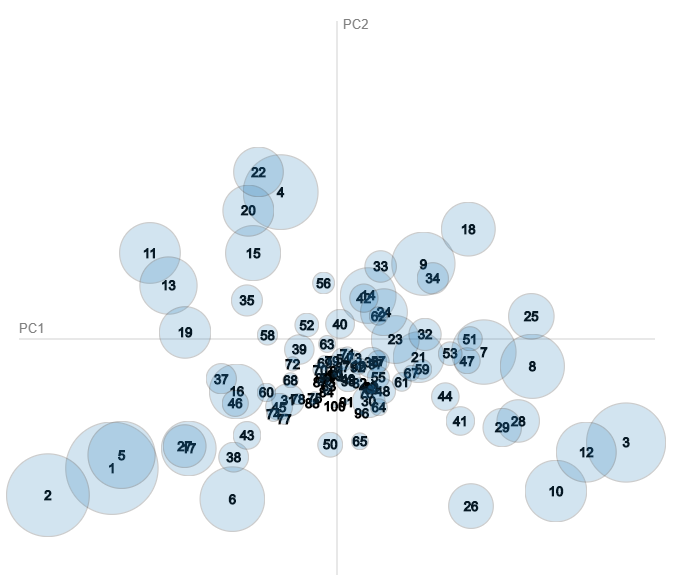, topics on the left are more social science, politics, literature related while topics on the right are primarily talk about more sciency articles. 
